#### Broad Steps
- Read image in as numbers
- select number of clusters
- graph color space
- graph clustered color space
- compare clustered and normal images

### Read Photo in as numbers to be clustered

In [ ]:
import plotly.express as px


In [47]:
def pixel_to_images(pixels, show=True):
    image = Image.fromarray(pixels)
    imshow(image)
    return image

In [167]:
from PIL import Image
class ClusterImage:
    def __init__(self, filename):
        self.image_obj = Image.open(filename).convert('RGB')
        self.shape = np.shape(np.array(self.imageobj))
        self.image_array = (np.array(self.imageobj))
        self.clustered_image_array = None
        self.cluster_image_obj = None

    def get_clustered_image(self, clusters = 10, clustering_type = "KMeans"):
    # shape = np.shape(image_array)
    # image_array = np.reshape(image_array, (shape[0] * shape[1], shape[2]))
        match clustering_type:
            case "Kmeans":
                kmeans = KMeans(n_clusters=clusters, random_state=0, max_iter = 10, n_init=1).fit(self.image_array)
                for i, pixel in enumerate(tqdm(image_array)):
                    cluster = kmeans.labels_[i]
                    image_array[i] = [int(samp) for samp in kmeans.cluster_centers_[cluster] ]
                return image_array


immy = ClusterImage('rainb.jpg')

In [160]:
from PIL import Image
import numpy as np
from matplotlib.pyplot import imshow

FILENAME = "rainb.jpg"
image = Image.open(FILENAME).convert('RGB')

# pixels_raw = np.array(image)
shape = np.shape(np.array(image))
image_array = np.reshape(np.array(image), (shape[0] * shape[1], shape[2]))
pixels_raw = np.reshape(image_array, shape)


100%|██████████| 264600/264600 [00:00<00:00, 309822.28it/s]


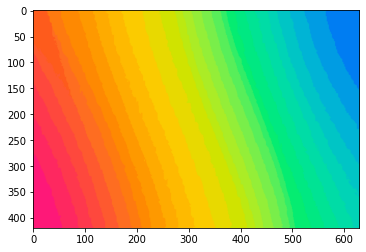

In [122]:
from sklearn.cluster import KMeans
from tqdm import tqdm

def get_clustered_image(cluster_image, clusters = 10, clustering_type = "KMeans"):
    # shape = np.shape(image_array)
    image_array = np.reshape(image_array, (shape[0] * shape[1], shape[2]))
    if clustering_type=="KMeans":
        kmeans = KMeans(n_clusters=clusters, random_state=0, max_iter = 10, n_init=1).fit(image_array)
        for i, pixel in enumerate(tqdm(image_array)):
            cluster = kmeans.labels_[i]
            image_array[i] = [int(samp) for samp in kmeans.cluster_centers_[cluster] ]
        return image_array


image_clustered, og_shape = get_clustered_image(pixels_raw, 30)
image_reshaped = np.reshape(image_clustered, og_shape)
image = pixel_to_images(image_reshaped)


### Plot Original and Transformed ColorSpace

In [123]:
import webcolors

def closest_colour(requested_colour):
    min_colours = {}
    for key, name in webcolors.CSS3_HEX_TO_NAMES.items():
        r_c, g_c, b_c = webcolors.hex_to_rgb(key)
        rd = (r_c - requested_colour[0]) ** 2
        gd = (g_c - requested_colour[1]) ** 2
        bd = (b_c - requested_colour[2]) ** 2
        min_colours[(rd + gd + bd)] = name
    return min_colours[min(min_colours.keys())]

def get_colour_name(requested_colour):
    try:
        closest_name = actual_name = webcolors.rgb_to_name(requested_colour)
    except ValueError:
        closest_name = closest_colour(requested_colour)
        actual_name = None
    if actual_name == None:
        return "Unknown Color"
    else:
        return actual_name
    return actual_name, closest_name

# requested_colour = (119, 172, 152)
# name = get_colour_name(requested_colour)



In [156]:
def display_colors(image_info):
    colors = np.unique(image_info, axis=0)
    color_names = []
    for col in (colors):
        color_names.append('Unknown Color')
    data = list(map(list, zip(colors[:,0], colors[:,1],colors[:,2],color_names)))
    new_df = pd.DataFrame(data,columns=['Red','Green','Blue', "Name"])
    colfig = px.scatter_3d(new_df, x='Red', y='Green', z='Blue',
                color='Blue')
    colfig.show()

display_colors(image_array)

In [159]:
def display_colors(image_info):
    colors = np.unique(image_info, axis=0)
    color_names = []
    for col in (colors):
        color_names.append('Unknown Color')
    data = list(map(list, zip(colors[:,0], colors[:,1],colors[:,2],color_names)))
    new_df = pd.DataFrame(data,columns=['Red','Green','Blue', "Name"])
    colfig = px.scatter_3d(new_df, x='Red', y='Green', z='Blue',
                color='Blue')
    colfig.show()
display_colors(image_clustered)

In [302]:

encoding = encode(image_array, og_shape, "image_uncompressed.txt")
encoding = encode(image_clustered, og_shape, "image.txt")

### Encoding Scheme

First 23 bits are number of occurrences, next 8 are R, next 8 are G, next 8 are B


OR

combine hashmap and RLE

first n lines are cluster_number and pixel associations, at least 25 bits (1 bit for cluster, 24 bits for RGB)
then RLE encoded image for cluster numbers

decode first n lines into hash map then decode remainder

In [304]:
# Perform Run–length encoding (RLE) data compression algorithm on string `str`
def encode(arr, shape, saveName = False):
    NUM_OCCURENCES_BITS = 23

    encoding = [] # stores output string

    encoding.append(f'{0:0{NUM_OCCURENCES_BITS}b}{shape[0]:0{8}b}{shape[1]:0{8}b}{shape[2]:0{8}b}'.encode('utf-8') )
    i = 0
    while i < len(arr):
        # count occurrences of character at index `i`
        count = 1
        while i + 1 < len(arr) and np.array_equal(arr[i], arr[i + 1]):
            print('test')
            count = count + 1
            i = i + 1
 
        # append current character and its count to the result
        bit_string = f'{count:0{NUM_OCCURENCES_BITS}b}{arr[i][0]:0{8}b}{arr[i][1]:0{8}b}{arr[i][2]:0{8}b}'.encode('utf-8')

        encoding.append(bit_string)
        i = i + 1
    if saveName:
        with open(saveName, 'wb') as file:
            for enc in encoding:
                file.write(enc)
    return encoding

In [181]:
def decode(enc_arr):
    image_array = []
    start = True
    for encoded in tqdm(enc_arr):
        if start:
            shape = encoded
            start = False
        for i in range(encoded[0]):
            image_array.append(encoded[1])
    print(shape[1:3])
    image = np.reshape(image_array, shape[1:3])
    return image

In [191]:
encode

array([3.59041688e-311, 6.36598860e-314, 1.69759670e-313, ...,
       4.47741112e-312, 4.81693045e-312, 4.60473087e-312])

In [223]:
# np.save("encoded_frog.npy", encoding)
encoding_read = np.load("encoded_frog.npy")
image = decode(encoding_read)
image = Image.fromarray(image)

100%|██████████| 697054/697054 [00:01<00:00, 574654.25it/s]


[1691 2484]


(168, 61, 3)
10248


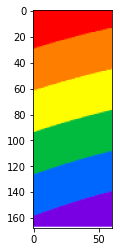

In [275]:
def decode_file(filename):
    file = open(filename, "rb")
    file_data = file.read()
    ran =len(file_data)//47
    start = True
    im_data = []
    for i in range(ran):
        line = file_data[(i*47):(i+1)*47]
        occ = int(line[:23], 2)
        r = int(line[23:31], 2)
        g = int(line[31:39], 2)
        b = int(line[39:], 2)
        if start:
            shape = (r,g,b)
            start=False
        else:
            for num in range(occ):
                im_data.append([r,g,b])
    return np.reshape(im_data, shape)
immy = decode_file("image.bin")
imshow(immy)

In [ ]:
#implement scikit learn solution and verify it works
#imlement knn myself